In [1]:
import numpy as np

seed_ = 20200218

np.random.seed(seed_)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
color_palette = sns.color_palette("muted")
sns.set_palette(color_palette)


# Sk-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


def create_fig(figsize=(8,5), dpi=150):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    return fig

In [2]:
df = pd.read_csv("./data/train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 
## Fill na & drop outlier

- จาก EDA Embark fill = C
- มี fare outlier

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df['Age'].fillna(np.floor(df['Age'].mean()), inplace=True)

In [7]:
df['Embarked'].fillna('C', inplace=True)

In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

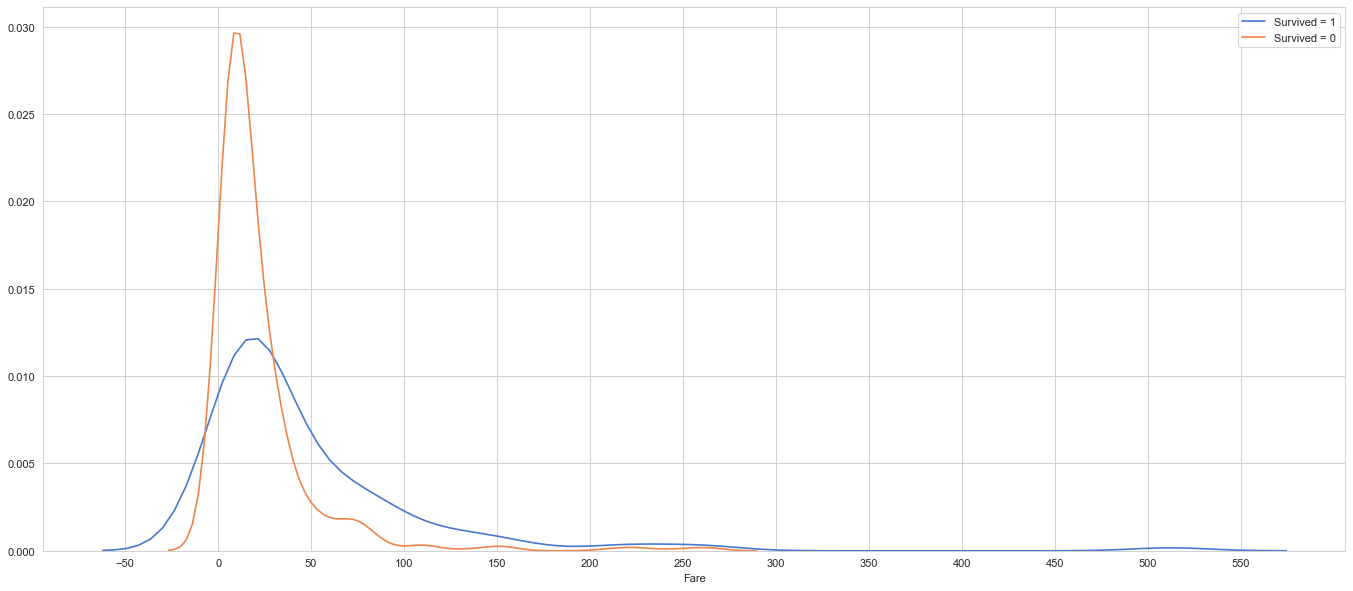

In [9]:
create_fig(figsize=(21, 9), dpi=80)
df_variable = 'Fare'
sns.kdeplot(df[df['Survived'] == 1][df_variable], label='Survived = 1')
sns.kdeplot(df[df['Survived'] == 0][df_variable], label='Survived = 0')
plt.xlabel(df_variable)
plt.xticks(np.arange(-50, 600, 50))
plt.show()

In [10]:
df.drop(df[df['Fare'] > 300].index, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  888 non-null    int64  
 1   Survived     888 non-null    int64  
 2   Pclass       888 non-null    int64  
 3   Name         888 non-null    object 
 4   Sex          888 non-null    object 
 5   Age          888 non-null    float64
 6   SibSp        888 non-null    int64  
 7   Parch        888 non-null    int64  
 8   Ticket       888 non-null    object 
 9   Fare         888 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     888 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.2+ KB


In [12]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000
mean,445.618243,0.381757,2.313063,29.540732,0.524775,0.381757,30.582164
std,257.405474,0.486091,0.834007,13.022614,1.104186,0.806949,41.176366
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,445.500000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,667.250000,1.000000,3.000000,35.000000,1.000000,0.000000,30.771850
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000


## Replace Sex
- male = 1
- female = 0

In [13]:
def replace_sex(df):
    df['Sex'] = (df['Sex'] == 'male').astype(int)
    return df

## onehot Encode Embarked

In [14]:
def onehot_embarked(df):
    return pd.get_dummies(df, columns=['Embarked'])

In [15]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']
df = df[columns]
df = replace_sex(df)
df = onehot_embarked(df)

In [17]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,0,0,0,1
1,1,0,38.0,1,0,71.2833,1,1,0,0
2,3,0,26.0,0,0,7.9250,1,0,0,1
3,1,0,35.0,1,0,53.1000,1,0,0,1
4,3,1,35.0,0,0,8.0500,0,0,0,1


In [19]:
df.to_csv("./data/train_cleaned.csv", index=False)